In [3]:
'''
Copyright (c) 2020
Author:
  Bruno Ferrarini (University of Essex)
This project is licensed under MIT.
'''

"""
    This tuttorial shows how to design and train a simple Binary Neural Network with LARQ framework
    The experiments are:
        1) a regular full precision CNN is trained on MNIST
        2) as in 1) with the addition of BatchNormalization. BatchNorm is mandatory for BNN, thus this model represents a comparison baseline for the BNN
        3) The same CNN as in 1) is built using LARQ layers w/o binarization. This experiment is to show the equivalence between Keras ans LARQ layers.
        4) A Binary Network is trained on MNIST. The hyperparamenter used for the layers are the same as the above models
        5) The experiment 4 is repeated w/o batchNorm showing that BNN cannot be trained.

"""

'\n    This tuttorial shows how to design and train a simple Binary Neural Network with LARQ framework\n    The experiments are:\n        1) a regular full precision CNN is trained on MNIST\n        2) as in 1) with the addition of BatchNormalization. BatchNorm is mandatory for BNN, thus this model represents a comparison baseline for the BNN\n        3) The same CNN as in 1) is built using LARQ layers w/o binarization. This experiment is to show the equivalence between Keras ans LARQ layers.\n        4) A Binary Network is trained on MNIST. The hyperparamenter used for the layers are the same as the above models\n        5) The experiment 4 is repeated w/o batchNorm showing that BNN cannot be trained.\n\n'

In [4]:
import larq
import tensorflow as tf
# example of loading the MNIST dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import numpy as np

In [5]:
"""
    Building Functions.
"""

def get_fp_model(input_shape, use_bn = False):
    input_image = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation=None)(input_image)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(input_image, x)
    return model

def get_larq_fp(input_shape, use_bn = False):
    input_image = Input(shape=input_shape)
    x = larq.layers.QuantConv2D(32, (3, 3), activation=None)(input_image)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = larq.layers.QuantConv2D(64, (3, 3), activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = larq.layers.QuantDense(64, activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = larq.layers.QuantDense(10, activation='softmax')(x)
    model = Model(input_image, x)
    return model

def binary_model(input_shape, use_bn = False):
    input_image = Input(shape=input_shape)
    x = larq.layers.QuantConv2D(32, (3, 3), 
        kernel_quantizer='ste_sign', 
        input_quantizer=None, 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=False )(input_image)
    if use_bn:
        x = BatchNormalization()(x)
    #x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = larq.layers.QuantConv2D(64, (3, 3), 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=False)(x)
    if use_bn:
        x = BatchNormalization()(x)
    #x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = larq.layers.QuantDense(64, 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=False)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    #x = ReLU()(x)
    x = larq.layers.QuantDense(10, 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=False,    
        activation='softmax')(x)
    model = Model(input_image, x)
    return model


In [6]:
"""
    This function loads MNIST data and reshapes the samples by adding the channel dimension
"""

def load_mnist(display=False):
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    print("TrainX {}".format(trainX.shape))
    print('TestX {}'.format(testX.shape))
    print('Train: X={}, y={}'.format(trainX.shape, trainY.shape))
    print('Test: X={}, y={}'.format(testX.shape, testY.shape))
    # expand dims to add the channel dimension
    trainX = np.expand_dims(trainX, axis=-1)
    testX = np.expand_dims(testX, axis=-1)
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY) 

    if display:
        for i in range(9):
            # define subplot
            pyplot.subplot(330 + 1 + i)
            # plot raw pixel data
            pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
            pyplot.xticks([])
            pyplot.yticks([])
        pyplot.show()

    return (trainX, trainY), (testX, testY)


In [7]:
#TRAIN PARAMETERS
batch_size = 64
# Comment this to enable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

TrainX (60000, 28, 28)
TestX (10000, 28, 28)
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


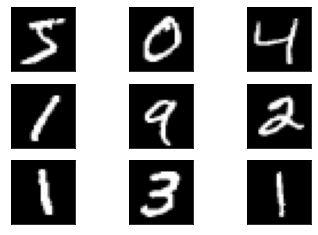

In [8]:
#  MNIST DATA ARE LOADED AND PRE-PROCESSED

mnist_train, mnist_test = load_mnist(display=True)
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_iterator = datagen.flow(mnist_train[0],  mnist_train[1], batch_size=batch_size)
test_iterator = datagen.flow(mnist_test[0], mnist_test[1], batch_size=batch_size)

input_shape = mnist_test[0][0].shape

In [9]:
#################
# EXPERIEMENT 1 #
#################

# FP MODEL on MNIST
model = get_fp_model(input_shape, use_bn = False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
re_lu (ReLU)                 (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)         

Epoch 1/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1654 - accuracy: 0.9512 - val_loss: 0.0620 - val_accuracy: 0.9807
Epoch 2/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0521 - accuracy: 0.9841 - val_loss: 0.0377 - val_accuracy: 0.9868
Epoch 3/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0317 - val_accuracy: 0.9877
Epoch 4/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.0315 - val_accuracy: 0.9892
Epoch 5/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.0346 - val_accuracy: 0.9885
Epoch 6/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0297 - val_accuracy: 0.9895
Epoch 7/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0324 - val_accuracy:

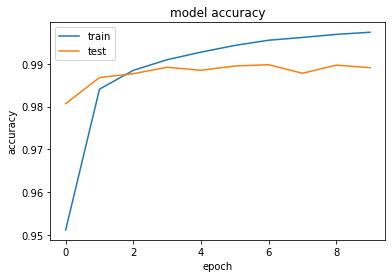

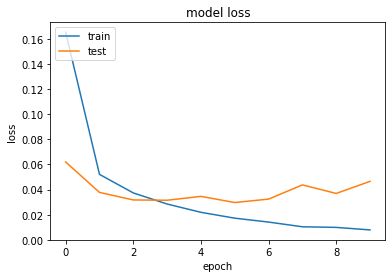

In [10]:
# FP MODEL on MNIST
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Epoch 1/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1117 - accuracy: 0.9723 - val_loss: 0.0511 - val_accuracy: 0.9821
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0392 - accuracy: 0.9887 - val_loss: 0.0519 - val_accuracy: 0.9827
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0355 - val_accuracy: 0.9880
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.0324 - val_accuracy: 0.9900
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0298 - val_accuracy: 0.9904
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.0463 - val_accuracy: 0.9865
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.0278 - val_accuracy: 0.9904
Epoch 

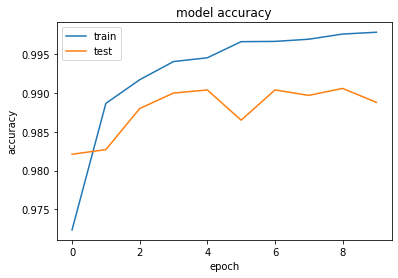

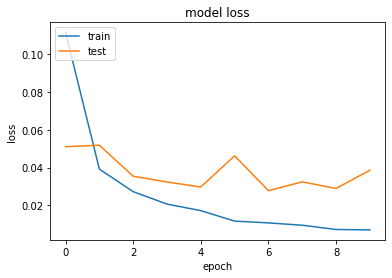

In [9]:
#################
# EXPERIEMENT 2 #
#################

# FP MODEL with BN on MNIST
model = get_fp_model(input_shape, use_bn = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [102]:
#################
# EXPERIEMENT 3 #
#################

# LARQ FP MODEL with BN on MNIST
model = get_larq_fp(input_shape, use_bn = True) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1224 - accuracy: 0.9694 - val_loss: 0.0422 - val_accuracy: 0.9874
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0399 - accuracy: 0.9882 - val_loss: 0.0704 - val_accuracy: 0.9786
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0266 - accuracy: 0.9923 - val_loss: 0.0383 - val_accuracy: 0.9875
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0416 - val_accuracy: 0.9862
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0605 - val_accuracy: 0.9817
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.0387 - val_accuracy: 0.9876
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0288 - val_accuracy: 0.9910
Epoch 

Epoch 1/20
938/938 [==============================] - 7s 8ms/step - loss: 0.1165 - accuracy: 0.9714 - val_loss: 0.0505 - val_accuracy: 0.9839
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.0421 - val_accuracy: 0.9852
Epoch 3/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.0401 - val_accuracy: 0.9880
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.0394 - val_accuracy: 0.9868
Epoch 5/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 0.0295 - val_accuracy: 0.9904
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0128 - accuracy: 0.9959 - val_loss: 0.0292 - val_accuracy: 0.9906
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 

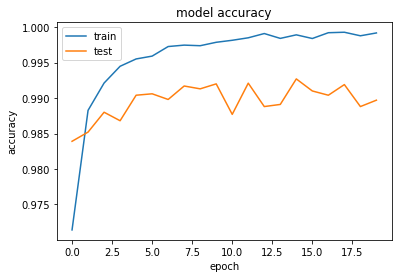

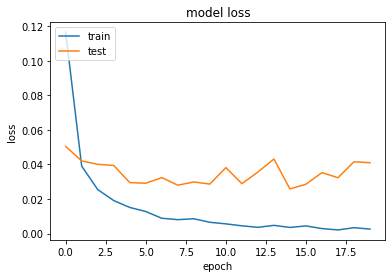

In [105]:
# Same as above but with BatchNorm
model = get_larq_fp(input_shape, use_bn = False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Epoch 1/10
938/938 [==============================] - 7s 8ms/step - loss: 2.2793 - accuracy: 0.7193 - val_loss: 1.1078 - val_accuracy: 0.8423
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.9581 - accuracy: 0.8677 - val_loss: 0.7337 - val_accuracy: 0.8916
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.6976 - accuracy: 0.8995 - val_loss: 0.5708 - val_accuracy: 0.9173
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.5894 - accuracy: 0.9125 - val_loss: 0.5256 - val_accuracy: 0.9246
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.5156 - accuracy: 0.9223 - val_loss: 0.4265 - val_accuracy: 0.9365
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4766 - accuracy: 0.9277 - val_loss: 0.5154 - val_accuracy: 0.9254
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4333 - accuracy: 0.9354 - val_loss: 0.4434 - val_accuracy: 0.9330
Epoch 

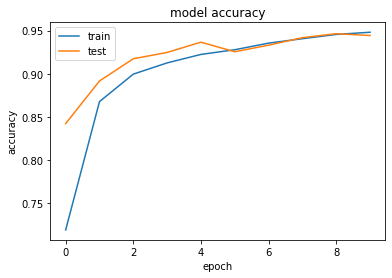

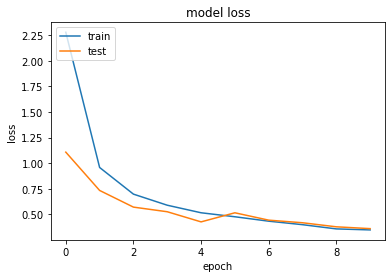

In [128]:
#################
# EXPERIEMENT 4 #
#################

# Binary Model training
model = binary_model(input_shape, use_bn = True)
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
    )
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=20)
# LARQ FP MODEL with BN on MNIST
# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Epoch 1/20
938/938 [==============================] - 6s 6ms/step - loss: 6.4913 - accuracy: 0.2912 - val_loss: 10.3008 - val_accuracy: 0.0976
Epoch 2/20
938/938 [==============================] - 6s 6ms/step - loss: 6.1322 - accuracy: 0.1028 - val_loss: 7.4560 - val_accuracy: 0.1032
Epoch 3/20
938/938 [==============================] - 6s 6ms/step - loss: 5.4754 - accuracy: 0.1013 - val_loss: 6.9143 - val_accuracy: 0.1032
Epoch 4/20
938/938 [==============================] - 6s 6ms/step - loss: 5.2664 - accuracy: 0.1017 - val_loss: 6.0169 - val_accuracy: 0.0980
Epoch 5/20
938/938 [==============================] - 6s 6ms/step - loss: 4.7784 - accuracy: 0.1009 - val_loss: 4.3371 - val_accuracy: 0.0979
Epoch 6/20
938/938 [==============================] - 6s 6ms/step - loss: 4.3637 - accuracy: 0.1012 - val_loss: 5.5919 - val_accuracy: 0.0980
Epoch 7/20
938/938 [==============================] - 6s 6ms/step - loss: 4.6248 - accuracy: 0.1013 - val_loss: 9.9913 - val_accuracy: 0.0974
Epoch

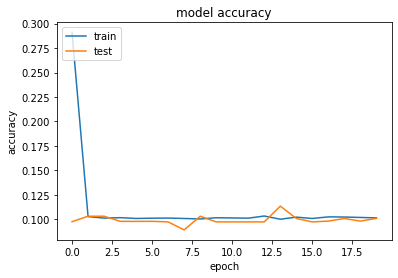

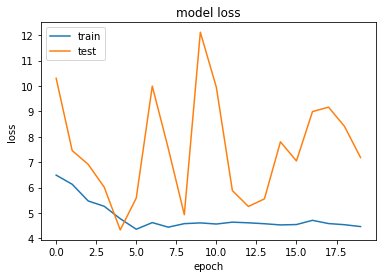

In [129]:
#################
# EXPERIEMENT 5 #
#################

# Binary Model training w/o BatchNorm
model = binary_model(input_shape, use_bn = False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)
# LARQ FP MODEL with BN on MNIST
# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()